<a href="https://colab.research.google.com/github/aiaaee/Policy-Improvement-Methods-Analysis/blob/main/Policy_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gym==0.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.8 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.13.1-py3-none-any.whl size=1635609 sha256=f31102f6c0ed6dba71a34662a6e955ac4551a3e9a89475f04c29cbfc0933ee75
  Stored in directory: /root/.cache/pip/wheels/3d/28/b6/0075715723dfcefa7b52ae6a805898eb5b99f717638d690ffb
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 3.1.2
    Uninstalling cloudpickle-3.1.2:
      Successfully uninstalled cloudpickle-3.1.2
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2025.9.1 requires cloudpickle>=

In [3]:
import numpy as np
import warnings ; warnings.filterwarnings('ignore')
import sys
# import gymnasium as gym
import matplotlib.pyplot as plt
import gym

## Policy Improvement

In [ ]:
def pure_exploitation(env , n_episodes=1000):
  Q = np.zeros((env.action_space.n) , dtype=np.float64)
  N = np.zeros((env.action_space.n) , dtype=np.int64)
  Qe = np.empty((n_episodes , env.action_space.n) , dtype=np.float64)
  returns = np.empty(n_episodes , dtype=np.float64)
  actions = np.empty(n_episodes , dtype=np.int64)
  for e in range(n_episodes):
    action = np.argmax(Q)
    _ , reward , _ , _ = env.step(action)
    N[action] += 1
    Q[action] = Q[action] + (reward - Q[action]) / N[action]

    Qe[e] = Q
    returns[e] = reward
    actions[e] = action
  return returns , Qe , actions

In [ ]:
def pure_exploration(env , n_episodes=1000):
  Q = np.zeros((env.action_space.n) , dtype=np.float64)
  N = np.zeros((env.action_space.n) , dtype=np.int64)
  Qe = np.empty((n_episodes , env.action_space.n) , dtype=np.float64)

  returns = np.empty(n_episodes , dtype=np.float64)
  actions = np.empty(n_episodes , dtype=np.int64)

  for e in range(n_episodes):
    action = np.random.randint(len(Q))
    _ , reward , _ , _ = env.step(action)
    N[action] += 1
    Q[action] = Q[action] + (reward - Q[action]) / N[action]

    Qe[e] = Q
    returns[e] = reward
    actions[e] = action
  return returns , Qe , actions


In [ ]:
def epsilon_greedy(env , epsilon , n_episodes=1000):
  Q = np.zeros((env.action_space.n) , dtype=np.float64)
  N = np.zeros((env.action_space.n) , dtype=np.int64)
  Qe= np.empty((n_episodes , env.action_space.n) , dtype=np.float64)

  returns = np.empty(n_episodes , dtype=np.float64)
  actions = np.empty(n_episodes , dtype=np.int64)

  for e in range(n_episodes) :

    if np.random.uniform() > epsilon :
      action = np.argmax(Q)
    else :
      action = np.random.randint(len(Q))

    _, reward, _, _ = env.step(action)
    N[action] += 1
    Q[action] = Q[action] + (reward - Q[action])/N[action]

    Qe[e] = Q
    returns[e] = reward
    actions[e] = action
  return returns, Qe, actions

## Bandit_Two_Armed_Uniform

In [ ]:
class TwoBanditArm():
  def __init__(self , mean_1 = 0.8 , mean_2 = 0.9):
    self.means = [mean_1 , mean_2]

  def reset(self) :
    return None , {}

  def step(self , action):
    assert action in [0 , 1 ]
    reward = 1 if np.random.random() < self.means[action] else 0
    next_state , terminated , truncated , info = None , True , False , {}
    return next_state , reward , terminated , truncated , info

  def render(self):
    print(f"Two_Armed Bandint | True Means : Arm0={self.means[0]} , Arm1={self.means[1]}")


In [ ]:
env = TwoBanditArm(mean_1 = 0.2 , mean_2 = 0.5)
for episoed in range(10):
  obs , info = env.reset()
  env.render()

  action = np.random.randint(0 ,2  )
  print(f"Agent chose arm {action}")



Two_Armed Bandint | True Means : Arm0=0.2 , Arm1=0.5
Agent chose arm 1
Two_Armed Bandint | True Means : Arm0=0.2 , Arm1=0.5
Agent chose arm 0
Two_Armed Bandint | True Means : Arm0=0.2 , Arm1=0.5
Agent chose arm 1
Two_Armed Bandint | True Means : Arm0=0.2 , Arm1=0.5
Agent chose arm 1
Two_Armed Bandint | True Means : Arm0=0.2 , Arm1=0.5
Agent chose arm 1
Two_Armed Bandint | True Means : Arm0=0.2 , Arm1=0.5
Agent chose arm 1
Two_Armed Bandint | True Means : Arm0=0.2 , Arm1=0.5
Agent chose arm 1
Two_Armed Bandint | True Means : Arm0=0.2 , Arm1=0.5
Agent chose arm 0
Two_Armed Bandint | True Means : Arm0=0.2 , Arm1=0.5
Agent chose arm 0
Two_Armed Bandint | True Means : Arm0=0.2 , Arm1=0.5
Agent chose arm 1


In [ ]:
class SimpleBanditEnv :
  def __init__(self , true_action_values):
    self.true_action_values = np.array(true_action_values)
    self.action_space = type('', (), {})()
    self.action_space.n = len(true_action_values)

  def step(self , action):
    reward = np.random.randn() + self.true_action_values[action]
    return None , reward , None , None

In [ ]:
env = SimpleBanditEnv([0.2 , 0.5 , -0.1 , 1.0])

In [ ]:
returns , Qe  , actions = epsilon_greedy(env , epsilon=0.1 , n_episodes=1000)

In [ ]:
import matplotlib.pyplot as plt

def plot_results(returns, label):
    avg_rewards = np.cumsum(returns) / (np.arange(len(returns)) + 1)
    plt.plot(avg_rewards, label=label)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)

In [ ]:
returns_eps , _ , _ = epsilon_greedy(env , epsilon=0.1)
returns_explore , _ , _ = pure_exploration(env)
returns_exploit , _ , _ = pure_exploitation(env)

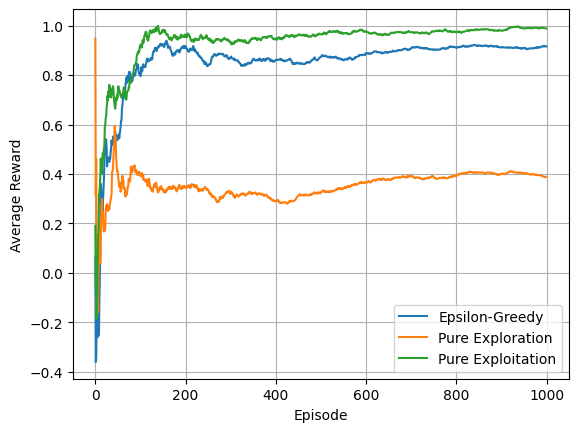

In [ ]:
plot_results(returns_eps , label='Epsilon-Greedy')
plot_results(returns_explore , label='Pure Exploration')
plot_results(returns_exploit , label='Pure Exploitation')

## N-chain RL

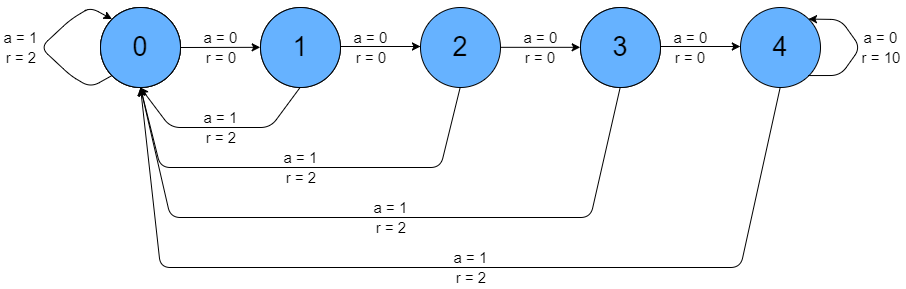

In [4]:
env = gym.make("NChain-v0", n=5, slip=0.2, small=2, large=10)

In [5]:
print('Number of actions:' , env.action_space.n)
print('Number of States: ' , env.observation_space.n)

Number of actions: 2
Number of States:  5


In [6]:
def epsilon_greedy(env , epsilon=0.1 , n_episodes=100):
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states , n_actions))
  returns = []
  state = env.reset()

  for ep in range(n_episodes):
    if np.random.rand() < epsilon :
      action = env.action_space.sample()
    else :
      action = np.argmax(Q[state])

    next_state , reward , terminated , truncated = env.step(action)
    Q[state , action] = Q[state , action] + 0.1 * (reward - Q[state , action])
    returns.append(reward)
    state = next_state

    if terminated or truncated :
      state = env.reset()
  return np.array(returns) , Q

In [7]:
state = env.reset()
next_state , reward , done , truncated = env.step(0)

In [8]:
def pure_exploitation(env , n_episodes=100):
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states , n_actions))
  returns = []
  state = env.reset()

  for ep in range(n_episodes):
    action = np.argmax(Q[state])

    next_state , reward , terminated , truncated = env.step(action)
    Q[state , action] = Q[state , action] + 0.1 * (reward - Q[state , action])
    returns.append(reward)
    state = next_state

    if terminated or truncated :
      state = env.reset()
  return np.array(returns) ,  Q



In [9]:
def pure_exploration(env , n_episodes=100):
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states , n_actions))
  returns = []
  state = env.reset()

  for ep in range(n_episodes):
    action = env.action_space.sample()

    next_state , reward , terminated , truncated = env.step(action)
    Q[state , action] = Q[state , action] + 0.1 * (reward - Q[state , action])
    returns.append(reward)
    state = next_state

    if terminated or truncated :
      state = env.reset()
  return np.array(returns) ,  Q

In [10]:
def softmax(env, init_temp=1.0, min_temp=0.01,
            decay_rate=0.995, n_episodes=1000 , alpha=0.1 , gamma=0.99 ):
    n_actions = env.action_space.n
    n_states = env.observation_space.n
    Q = np.zeros((n_states, n_actions))
    returns = []
    state = env.reset()
    temp = init_temp
    for e in range(n_episodes):
        temp = max(min_temp, temp * decay_rate)
        logits = Q[state] / temp
        logits -= np.max(logits)
        probs = np.exp(logits) / np.sum(np.exp(logits))
        action = np.random.choice(n_actions, p=probs)
        next_state, reward, terminated, truncated = env.step(action)
        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
        returns.append(reward)
        if terminated or truncated:
            state = env.reset()
        else:
            state = next_state

    return np.array(returns), Q


In [138]:
def upper_confidence_bound(env , C=2 , n_episodes=1000 ):
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states , n_actions))
  N = np.zeros((n_states , n_actions))

  returns = []
  state = env.reset()
  for e in range(n_states):
    U = np.zeros(n_actions)
    for a in range(n_actions):
      if N[state , a ] == 0 :
        U[a] = np.inf
      else :
        U[a] = C * np.sqrt(np.log(e + 1 ) / N[state , a])
    action = np.argmax(Q[state] + U)
    next_state , reward , terminated , truncated = env.step(action)

    N[state , action] += 1
    Q[state , action] = Q[state , action] + 0.1 * (reward - Q[state , action])

    returns.append(reward)
    state = next_state

    if terminated or truncated :
      state = env.reset()

  return np.array(returns ) , Q

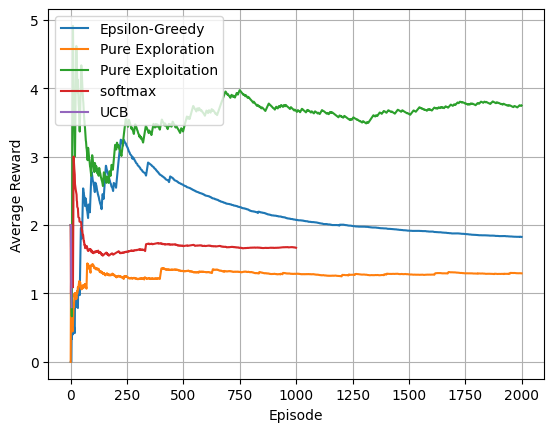

In [113]:
returns_eps, _ = epsilon_greedy(env, epsilon=0.1, n_episodes=2000)
returns_explore , _ = pure_exploration(env , n_episodes=2000)
returns_exploit , _ = pure_exploitation(env , n_episodes=2000)
returns_softmax , _ = softmax(env , init_temp=1.0, min_temp=0.01, decay_rate=0.995, n_episodes=1000 , alpha=0.1 , gamma=0.99 )
returns_ucb , _ = upper_confidence_bound(env , C=2 , n_episodes=2000)

epsilon_avg_rewards = np.cumsum(returns_eps) / (np.arange(len(returns_eps)) + 1)
explore_avg_rewards = np.cumsum(returns_explore) / (np.arange(len(returns_explore)) + 1)
exploit_avg_rewards = np.cumsum(returns_exploit) / (np.arange(len(returns_exploit)) + 1)
softmax_avg_rewards = np.cumsum(returns_softmax) / (np.arange(len(returns_softmax)) + 1)
ucb_avg_rewards = np.cumsum(returns_ucb) / (np.arange(len(returns_ucb)) + 1)

plt.plot(epsilon_avg_rewards, label="Epsilon-Greedy")
plt.plot(explore_avg_rewards, label="Pure Exploration")
plt.plot(exploit_avg_rewards, label="Pure Exploitation")
plt.plot(softmax_avg_rewards, label="softmax ")
plt.plot(ucb_avg_rewards , label="UCB")

plt.plot()
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()